# Option Pricing based on Heston and Black-Scholes Model

We use Monte Carlo simulation to implement the Heston and Black-Scholes model

In [1]:
import os
import time
import scipy
import pathlib
# import numba # potential speed up here
# import cupy as cp # only works with nvidia gpu
import numpy as np
import pandas as pd
from tqdm import tqdm

## 0 Heston model for scalar values

We first implement a scalar version of the model according to the following formulae.  

$$d S_t  = \mu S_t dt + \sqrt{\nu_t} S_t dW^S_t \\ d \nu_t = \kappa (\theta - \nu_t) dt + \xi \sqrt{\nu_t} dW^\nu_t$$  

which is discretized as  

$$
S_{i+1} = S_i \exp [\left(\mu - \frac{1}{2} v_i^{+}\right) \Delta t + \sqrt{v_i^{+}} \sqrt{\Delta t} \Delta W^S_{i+1}] \\
\nu_{i+1} = \nu_i + \kappa (\theta - \nu_i^{+}) \Delta t + \xi \sqrt{\nu_i^{+}} \Delta W^\nu_{i+1}
$$

In [2]:
# set some parameters
num_sims = 100000;   # Number of simulated asset paths
num_intervals = 1000;  # Number of intervals for the asset path to be sampled 

S_0 = 100.0;    # Initial spot price
K = 100.0;      # Strike price
r = 0.0319;     # Risk-free rate
v_0 = 0.010201; # Initial volatility 
T = 1.00;       # One year until expiry

rho = -0.7;     # Correlation of asset and volatility
kappa = 6.21;   # Mean-reversion rate
theta = 0.019;  # Long run average volatility
xi = 0.61;      # "Vol of vol"

In [3]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, num_sims):  
    '''
    Produces result for a single heston run.
    
    '''
    dt = T/steps
    # size = (num_sims, steps)
    # prices = np.zeros(size)
    # vols = np.zeros(size)
    S_t = S + np.zeros(num_sims)
    v_t = v_0 + np.zeros(num_sims)
    for t in tqdm(range(steps), colour="green"):
    # for t in range(steps):
        # [hex (#00ff00), BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE]
        WT1 = np.random.normal(0,1,size=num_sims)
        WT2 = np.random.normal(0,1,size=num_sims)
        WT3 = rho * WT1 + np.sqrt(1-rho**2)*WT2
        # WT = np.vstack((WT1, WT3)).T

        v_t = np.maximum(v_t, 0)
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t * dt) * WT1 )) #WT[:,0]
        v_t = v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t * dt)*WT3    #WT[:,1]
        # prices[:, t] = S_t # can be returned when plotting is required
        # vols[:, t] = v_t   # omitted to save memory 
    
    S_call = np.exp(-1 * r * T) * np.sum(np.maximum(S_t - K, 0)) / num_sims
    S_put = np.exp(-1 * r * T) * np.sum(np.maximum(K-S_t, 0)) / num_sims
    nu_avg = np.mean(v_t)
    
    return [S_call, S_put, nu_avg]

In [4]:
result = generate_heston_paths(S_0, T, r, kappa, theta, v_0,
                      rho, xi, num_intervals, num_sims)

100%|██████████| 1000/1000 [00:08<00:00, 121.31it/s]


In [5]:
for x in result:
  print(x)

6.859398806658789
3.688731528432195
0.019424100090998125


## 1 Heston model for vector values 

To produce a large number of results, we need to utilize the built-in vectorization in `numpy`.

We first load data for experiment and preprocess (roughly)

In [12]:
parent_path = str(pathlib.Path(os.getcwd()).parent)
df = pd.read_csv(os.path.join(parent_path, 'data/roughwork.csv'))
df.head()

,Unnamed: 0,optionid,securityid,strike,expiration,callput,contractsize,date_traded,contract_price,asset_price,contract_volume,days_to_maturity,rate,volatility
0,0,164100236.0,701057.0,22500.0,2020-03-20,C,2.0,2020-03-13,7.0,15938.0,152.0,7.0,0.858947,0.78887
1,1,164100240.0,701057.0,24500.0,2020-03-20,C,2.0,2020-03-13,22.0,15938.0,31.0,7.0,0.858947,0.78887
2,2,165303462.0,701057.0,22750.0,2020-03-20,C,2.0,2020-03-13,10.0,15938.0,7.0,7.0,0.858947,0.78887
3,3,165303464.0,701057.0,23750.0,2020-03-20,C,2.0,2020-03-13,6.0,15938.0,14.0,7.0,0.858947,0.78887
4,4,165303465.0,701057.0,24250.0,2020-03-20,C,2.0,2020-03-13,7.0,15938.0,3.0,7.0,0.858947,0.78887


Here we use (almost) the same approach to model average long run volatility $\theta$, mean reversion rate of volatility $\kappa$, and the variance of volatility $\xi$.  

**Question:** Is this the best approach? Are there better approaches? Perhaps options with the same underlying assest should take correlated values?

In [13]:
# divide by contract size for single share
df.strike = df.strike / (df.contractsize*1000)
df.asset_price = df.asset_price / (df.contractsize*1000)
df.contract_price = df.contract_price / df.contractsize

# divide by 365 for days to maturity ?
df.days_to_maturity = df.days_to_maturity #/ 365

# drop contract volume
df.drop(['contract_volume'], axis = 1)

# drop small strike prices
df = df.drop(df[df.strike<0.1].index)


# add moneyness
df['moneyness'] = df.strike / df.asset_price

# We may  add the following to the function for heston simulation

# add average long run volatility (theta)
df['mean_volatility'] = 0.001 + 0.05 * np.random.rand(len(df))

# add mean reversion rate of volatility (kappa)
df['reversion'] = 0.01 + 5 * np.random.rand(len(df))

# add variance of volatility
df['var_of_vol'] = 0.01 + 0.7 * np.random.rand(len(df))

# add correlation between random processes  
df['rho'] = -0.05 - 0.7 * np.random.rand(len(df))

df.head()

df.to_csv(os.path.join(parent_path, 'data/processed_data.csv'))

In [52]:
def generate_heston_vec(df, steps=1000, num_sims=100000):  

    '''
    Produces result for multiple heston runs for call options only.

    Args:  
        - df: dataframe, containing all parameters
        - steps: int, num time steps
        - num_sims: int, no. of simulations for each sample  

    Output:  
        - result: ndarray, containing average prices over num_sims
    '''  

    N     = len(df)
    # out   = np.zeros((N, ))
    dt    = df['days_to_maturity'].values /steps 
    S_t   = df['asset_price'].values 
    v_t   = df['volatility'].values 
    r     = df['rate'].values 
    theta = df['mean_volatility'].values 
    kappa = df['reversion'].values 
    xi    = df['var_of_vol'].values 
    K     = df['strike'].values 
    rho   = df['rho'].values 
    T     = df['days_to_maturity'].values
    
    for t in tqdm(range(steps), colour="green"):
        
        # the random normal samples are of shape (num_sims, N)
        WT1 = np.random.normal(0,1,size=(num_sims, N))
        WT2 = np.random.normal(0,1,size=(num_sims, N))
        WT3 = rho * WT1 + np.sqrt(1-rho**2)*WT2

        v_t = np.maximum(v_t, 0)
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t * dt) * WT1 )) 
        v_t = v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t * dt)*WT3
    
    S_call = np.exp(-1 * r * T) * np.sum(np.maximum(S_t - K, 0), axis = 0) / num_sims
    
    # S_put = np.exp(-1 * r * T) * np.sum(np.maximum(K-S_t, 0)) / num_sims
    nu_avg = np.mean(v_t)
    
    return S_call

## 2 Black-Scholes Model for vector values  

We implement the call/put option price of a Black-Scholes Model analystically according the following formulae.  

$$
\begin{aligned}
C(S,t) &= SN(d_1) - Ke^{-rT} N(d_2) \\
P(S,t) &= Ke^{-rT} - S + (SN(d_1) - Ke^{-rT} N(d_2))
\end{aligned}
$$  

where $N(x)$ is the cdf. of a standard normal distribution and $d_1,d_2$ are defined as  

$$
\begin{aligned}
d_1 &= \frac{\log(S/K) + (r+\frac{\sigma^2}{2})T}{\sigma \sqrt{T} }\\
d_2 &= d_1 - \sigma \sqrt{T}
\end{aligned}
$$

In [ ]:
def generate_bs_vec(df):
    """
    Produces result for multiple B-S runs for call options only (analytical).  

    Args:
        - df: dataframe, containing all parameters

    Output:
        - result: ndarray, containing prices for each sample
    """
    S   = df['asset_price'].values 
    vol   = df['volatility'].values 
    r     = df['rate'].values   
    K     = df['strike'].values  
    T     = df['days_to_maturity'].values / 365
    m     = df['moneyness'].values

    d1 = (np.log(m) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)

    S_call = S * scipy.stats.norm.cdf(d1) - \
        K * np.exp(-r * T) * scipy.stats.norm.cdf(d2)

    return S_call


## 1.1 Testing implementation  

We will test the implementation on a dummy dataset with repeated values; this is also useful for trying out models for the aforementioned constants.

In [53]:
# creates dummy dataset

N = len(df)

S_0 = np.repeat(100.0, N)     # Initial spot price
K = np.repeat(100.0, N)       # Strike price
r = np.repeat(0.0319, N)      # Risk-free rate
v_0 = np.repeat(0.010201,N)   # Initial volatility 
T = np.repeat(1.0, N)         # One year until expiry

rho = np.repeat(-0.7, N)      # Correlation of asset and volatility
kappa = np.repeat(6.21, N)    # Mean-reversion rate
theta = np.repeat(0.019,N)    # Long run average volatility
xi = np.repeat(0.61,N)        # "Vol of vol"  

dummy = pd.DataFrame(columns=['asset_price', 'strike', 'rate', 
                    'days_to_maturity', 'volatility', 'mean_volatility', 
                    'reversion', 'var_of_vol', 'rho'])

dummy['days_to_maturity'] = T
dummy['asset_price'] = S_0
dummy['volatility'] = v_0
dummy['rate'] = r
dummy['mean_volatility'] = theta
dummy['reversion'] = kappa
dummy['var_of_vol'] = xi
dummy['strike'] = K
dummy['rho'] = rho

dummy.head()

,asset_price,strike,rate,days_to_maturity,volatility,mean_volatility,reversion,var_of_vol,rho
0,100.0,100.0,0.0319,1.0,0.010201,0.019,6.21,0.61,-0.7
1,100.0,100.0,0.0319,1.0,0.010201,0.019,6.21,0.61,-0.7
2,100.0,100.0,0.0319,1.0,0.010201,0.019,6.21,0.61,-0.7
3,100.0,100.0,0.0319,1.0,0.010201,0.019,6.21,0.61,-0.7
4,100.0,100.0,0.0319,1.0,0.010201,0.019,6.21,0.61,-0.7


If tested on dummy dataset, then output should be approx. normally distributed which verifies the implementation of the heston model

In [56]:
# test_output = generate_heston_vec(dummy, 1000, 100)
test_output_heston = generate_heston_vec(df, 1000, 100)
test_output_bs = generate_bs_vec(df)

test_output_heston = np.sum((test_output_heston - df['contract_price'].values)**2) / len(df)
test_output_bs = np.sum((generate_bs_vec(df) - df['contract_price'].values)**2) / len(df)

print('MSE for Heston: ', test_output_heston)
print('MSE for B-S: ', test_output_bs)

100%|██████████| 1000/1000 [00:04<00:00, 232.45it/s]


(array([ 94., 105.,  98.,  83.,  74.,  54.,  65.,  57.,  47.,  43.,  37.,
         20.,  21.,  12.,   8.,  21.,   8.,   7.,  11.,  10.,   5.,   2.,
          4.,   1.,   3.,   6.,   5.,   5.,   2.,   2.,   4.,   3.,   4.,
          1.,   2.,   4.,   8.,   0.,   1.,   4.,   3.,   2.,   3.,   4.,
          1.,   2.,   1.,   0.,   1.,   0.,   1.,   1.,   2.,   1.,   1.,
          0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          1.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,
          0.,   1.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([2.28359452e-03, 3.39461230e-01, 6.76638865e-01, 1.01381650e+00,
        1.35099413e+00, 1.68817177e+00, 2.02534940e+00, 2.36252704e+00,
        2.69970467e+00, 3.03688231e+00, 3.37405994e+00, 3.71123758e+00,
        4.04841522e+00, 4.38559285e+00, 4.72277049e+00, 5.05994812e+00,
        5.39712576e+00, 5.7343

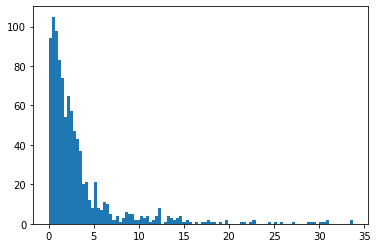

In [57]:
import matplotlib.pyplot as plt
plt.hist(test_output, bins = 100)